# Contact Classification

Download data from: https://utexas.box.com/s/5tvy96e01yett9kqdu5htdsvn9q6dtyc  
_Requires a UT account_  
Place the downloaded data in a folder `data/`

## Import statements

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re

## Parse data

### Read files

In [25]:
file_pattern = "*.csv"
data_path = os.fspath("data/dummy_data")
data_files = glob.glob(file_pattern, root_dir=data_path)

excluded_test_ids = {"lp0"}

print(f"Found {len(data_files)} data files")
test_id_set = set()
for file_name in data_files:
    file_prefix = file_name.split("_")[0]
    test_id_set.add(file_prefix)
for test_id in test_id_set:
    if test_id in excluded_test_ids:
        print(f"Unique Test ID: {test_id} : Excluded from test sets")
    else:
        print(f"Unique Test ID: {test_id} : Included in test sets")


Found 5 data files
Unique Test ID: lp1 : Included in test sets
Unique Test ID: lp2 : Included in test sets
Unique Test ID: lp0 : Excluded from test sets


### Append data files to Pandas dataframe

In [24]:
df_list = []
for file_name in data_files:
    file_prefix = file_name.split("_")[0]
    file = os.path.join(data_path, file_name)
    temp_df = pd.read_csv(file)
    temp_df.insert(0,"test_id",file_prefix)
    df_list.append(temp_df)
data_raw = pd.concat(df_list)
display(data_raw)
display(data_raw.dtypes)

,test_id,Time (s.ms),Force_gauge (N),Linear_position (mm),strain_0.0800m (µε),strain_1.2841m (µε),strain_0.0800m (µε).1,strain_0.0807m (µε),strain_0.0813m (µε),strain_0.0820m (µε),...,strain_1.2799m (µε),strain_1.2806m (µε),strain_1.2812m (µε),strain_1.2818m (µε),strain_1.2825m (µε),strain_1.2831m (µε),strain_1.2838m (µε),strain_1.2845m (µε),strain_1.2851m (µε),strain_1.2858m (µε)
0,lp0,44.662,0.00,-0.124756,-1.9,-4.3,-1.9,-7.0,-3.2,7.2,...,-15.000000,-12.000000,-7.000000,-0.6,-0.500000,-0.100000,-2.200000,-7.6,-2.7,-4.3
1,lp0,44.908,0.00,-0.124756,-8.4,-3.2,-8.4,-9.4,-4.6,-2.4,...,-20.299999,-19.200001,-6.600000,-11.3,-11.000000,2.300000,6.100000,-0.8,-2.4,-3.2
2,lp0,45.260,0.00,-0.124756,-1.8,-2.8,-1.8,-1.2,-0.1,-8.8,...,-14.500000,-16.000000,-2.400000,-6.2,-0.800000,5.900000,4.400000,2.9,-5.9,-2.8
3,lp0,45.463,0.00,-0.124756,-1.8,-6.2,-1.8,4.6,3.6,-4.8,...,-11.200000,-12.100000,-2.300000,3.5,-4.500000,2.800000,1.000000,3.7,-6.1,-6.2
4,lp0,45.809,0.00,-0.000244,-0.1,0.6,-0.1,8.8,0.8,-1.6,...,-16.299999,-9.400000,-1.700000,1.8,-6.900000,-0.500000,9.300000,1.6,1.9,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,lp2,55.749,0.14,3.865967,-1.5,8.6,-1.5,0.4,2.7,-1.2,...,18.600000,17.700001,24.200001,24.1,22.200001,19.500000,17.400000,12.6,14.7,8.6
150,lp2,56.049,0.14,3.865967,1.4,9.8,1.4,1.0,-1.1,-2.3,...,16.100000,9.000000,20.600000,15.2,15.300000,22.400000,19.900000,13.4,13.9,9.8
151,lp2,56.389,0.13,3.990479,1.5,14.4,1.5,-7.7,-4.2,-0.3,...,13.300000,11.600000,14.900000,9.1,15.400000,16.100000,24.700001,20.9,14.1,14.4
152,lp2,56.715,0.20,3.990479,-1.0,13.5,-1.0,-2.3,3.9,4.3,...,21.799999,22.700001,23.400000,18.5,12.400000,18.600000,12.000000,9.3,15.1,13.5


test_id                  object
Time (s.ms)             float64
Force_gauge (N)         float64
Linear_position (mm)    float64
strain_0.0800m (µε)     float64
                         ...   
strain_1.2831m (µε)     float64
strain_1.2838m (µε)     float64
strain_1.2845m (µε)     float64
strain_1.2851m (µε)     float64
strain_1.2858m (µε)     float64
Length: 1862, dtype: object

### Remove extra gauges and sort by position along sensor

In [16]:
data = data_raw.loc[:, ~data_raw.columns.str.contains(r"\.\d+$")]

strain_cols = [col for col in data.columns if col.startswith("strain")]
other_cols = [col for col in data.columns if col not in strain_cols]

x_axis_raw = np.array([float(re.search(r"strain_(.*)m", x).group(1)) for x in strain_cols])
sorted_idx = np.argsort(x_axis_raw)
x_axis = np.sort(x_axis_raw)
sorted_strain_cols = [strain_cols[i] for i in sorted_idx]
data = data[other_cols + sorted_strain_cols]
display(data)

,test_id,Time (s.ms),Force_gauge (N),Linear_position (mm),strain_0.0800m (µε),strain_0.0807m (µε),strain_0.0813m (µε),strain_0.0820m (µε),strain_0.0826m (µε),strain_0.0833m (µε),...,strain_1.2806m (µε),strain_1.2812m (µε),strain_1.2818m (µε),strain_1.2825m (µε),strain_1.2831m (µε),strain_1.2838m (µε),strain_1.2841m (µε),strain_1.2845m (µε),strain_1.2851m (µε),strain_1.2858m (µε)
0,lp0,44.662,0.00,-0.124756,-1.9,-7.0,-3.2,7.2,6.6,-1.6,...,-12.000000,-7.000000,-0.6,-0.500000,-0.100000,-2.200000,-4.3,-7.6,-2.7,-4.3
1,lp0,44.908,0.00,-0.124756,-8.4,-9.4,-4.6,-2.4,0.4,-3.1,...,-19.200001,-6.600000,-11.3,-11.000000,2.300000,6.100000,-3.2,-0.8,-2.4,-3.2
2,lp0,45.260,0.00,-0.124756,-1.8,-1.2,-0.1,-8.8,5.3,2.5,...,-16.000000,-2.400000,-6.2,-0.800000,5.900000,4.400000,-2.8,2.9,-5.9,-2.8
3,lp0,45.463,0.00,-0.124756,-1.8,4.6,3.6,-4.8,-2.9,5.1,...,-12.100000,-2.300000,3.5,-4.500000,2.800000,1.000000,-6.2,3.7,-6.1,-6.2
4,lp0,45.809,0.00,-0.000244,-0.1,8.8,0.8,-1.6,-6.1,-6.1,...,-9.400000,-1.700000,1.8,-6.900000,-0.500000,9.300000,0.6,1.6,1.9,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,lp2,55.749,0.14,3.865967,-1.5,0.4,2.7,-1.2,4.2,3.0,...,17.700001,24.200001,24.1,22.200001,19.500000,17.400000,8.6,12.6,14.7,8.6
150,lp2,56.049,0.14,3.865967,1.4,1.0,-1.1,-2.3,0.1,3.1,...,9.000000,20.600000,15.2,15.300000,22.400000,19.900000,9.8,13.4,13.9,9.8
151,lp2,56.389,0.13,3.990479,1.5,-7.7,-4.2,-0.3,-1.3,2.0,...,11.600000,14.900000,9.1,15.400000,16.100000,24.700001,14.4,20.9,14.1,14.4
152,lp2,56.715,0.20,3.990479,-1.0,-2.3,3.9,4.3,3.9,-6.6,...,22.700001,23.400000,18.5,12.400000,18.600000,12.000000,13.5,9.3,15.1,13.5


## Data Processing

### Visualize strain ranges

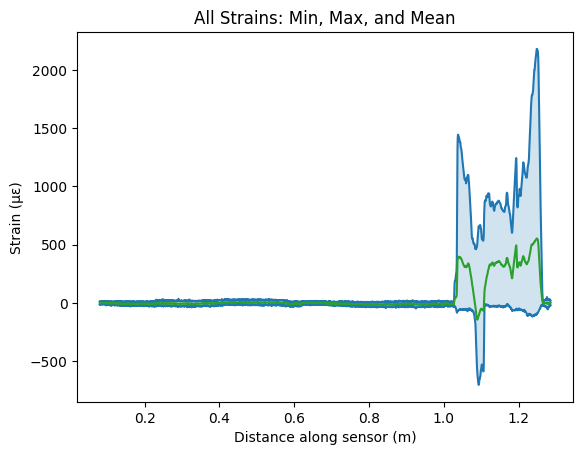

In [17]:
upper_bound = data[sorted_strain_cols].max()
lower_bound = data[sorted_strain_cols].min()
mean_line = data[sorted_strain_cols].mean()

fig, ax = plt.subplots()
ax.plot(x_axis,upper_bound,color='tab:blue')
ax.plot(x_axis,lower_bound,color='tab:blue')
ax.plot(x_axis,mean_line,color='tab:green')
ax.fill_between(x_axis,upper_bound,lower_bound,alpha=0.2)
ax.set_title("All Strains: Min, Max, and Mean")
ax.set_ylabel("Strain (με)")
ax.set_xlabel("Distance along sensor (m)")
plt.show()

### Cutoff excess early data

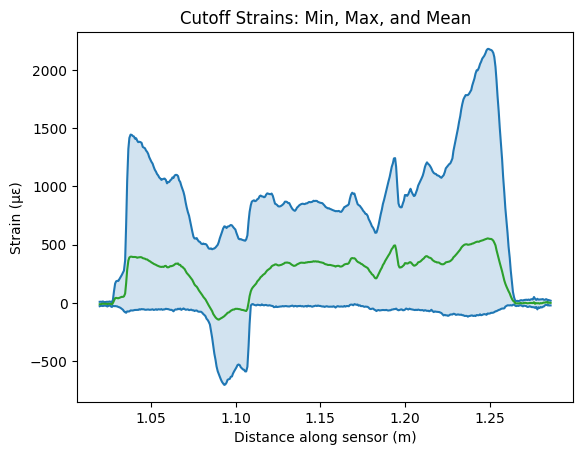

,strain_1.0199m (µε),strain_1.0206m (µε),strain_1.0212m (µε),strain_1.0218m (µε),strain_1.0225m (µε),strain_1.0231m (µε),strain_1.0238m (µε),strain_1.0244m (µε),strain_1.0251m (µε),strain_1.0258m (µε),...,strain_1.2806m (µε),strain_1.2812m (µε),strain_1.2818m (µε),strain_1.2825m (µε),strain_1.2831m (µε),strain_1.2838m (µε),strain_1.2841m (µε),strain_1.2845m (µε),strain_1.2851m (µε),strain_1.2858m (µε)
0,-8.9,-0.2,2.4,-4.1,-9.4,-5.0,-5.8,-1.3,-5.6,0.7,...,-12.000000,-7.000000,-0.6,-0.500000,-0.100000,-2.200000,-4.3,-7.6,-2.7,-4.3
1,-12.1,-3.6,-1.9,-7.5,-8.8,-2.6,1.5,-1.0,-2.9,-7.1,...,-19.200001,-6.600000,-11.3,-11.000000,2.300000,6.100000,-3.2,-0.8,-2.4,-3.2
2,-10.6,-22.1,-13.9,0.6,-4.0,-5.1,-5.3,-8.0,-5.1,-1.3,...,-16.000000,-2.400000,-6.2,-0.800000,5.900000,4.400000,-2.8,2.9,-5.9,-2.8
3,-8.9,-6.7,-12.4,-9.1,-7.1,-5.8,1.4,0.8,-10.4,-7.1,...,-12.100000,-2.300000,3.5,-4.500000,2.800000,1.000000,-6.2,3.7,-6.1,-6.2
4,-15.3,-10.5,-7.1,-5.7,-10.0,-4.3,-4.7,-5.1,-3.9,-9.7,...,-9.400000,-1.700000,1.8,-6.900000,-0.500000,9.300000,0.6,1.6,1.9,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,-5.5,-7.7,-0.2,-5.7,-8.2,-6.2,-6.3,-6.2,2.9,-2.2,...,17.700001,24.200001,24.1,22.200001,19.500000,17.400000,8.6,12.6,14.7,8.6
150,-7.3,-8.2,-5.4,-2.1,-1.0,3.2,-4.8,-18.6,-9.3,-2.1,...,9.000000,20.600000,15.2,15.300000,22.400000,19.900000,9.8,13.4,13.9,9.8
151,-8.0,-10.4,-8.8,4.2,1.7,2.6,-2.5,-11.9,-7.1,-3.1,...,11.600000,14.900000,9.1,15.400000,16.100000,24.700001,14.4,20.9,14.1,14.4
152,-9.2,-9.2,-7.3,-10.5,-7.1,-1.9,-1.7,-4.8,-9.4,-3.1,...,22.700001,23.400000,18.5,12.400000,18.600000,12.000000,13.5,9.3,15.1,13.5


In [23]:
start_location = 1.02
cutoff_idx = (np.abs(x_axis - start_location)).argmin()
cutoff_strain = data[sorted_strain_cols].iloc[:,cutoff_idx:]
cutoff_x_axis = x_axis[cutoff_idx:]

upper_bound = cutoff_strain.max()
lower_bound = cutoff_strain.min()
mean_line = cutoff_strain.mean()

fig, ax = plt.subplots()
ax.plot(cutoff_x_axis,upper_bound,color='tab:blue')
ax.plot(cutoff_x_axis,lower_bound,color='tab:blue')
ax.plot(cutoff_x_axis,mean_line,color='tab:green')
ax.fill_between(cutoff_x_axis,upper_bound,lower_bound,alpha=0.2)
ax.set_title("Cutoff Strains: Min, Max, and Mean")
ax.set_ylabel("Strain (με)")
ax.set_xlabel("Distance along sensor (m)")
plt.show()

### Remove NAN values

In [19]:
display(cutoff_strain.isna().sum().sum())
cutoff_strain.interpolate(inplace=True)
display(cutoff_strain.isna().sum().sum())


np.int64(0)

np.int64(0)

### Create classification labels

In [20]:
force_threshold = 0.01
contact_data = pd.DataFrame({"Contact": (data['Force_gauge (N)'] >= force_threshold).astype(int)})
display(contact_data.sum())

Contact    160
dtype: int64

## Train Model

### Create custom cross-validation splits

In [45]:
cv_split_array = np.zeros(len(data.test_id))
test_id_array = data.test_id.to_numpy()
i = 0
for test_id in test_id_set:
    if test_id in excluded_test_ids:
        split_idx = -1
    else:
        split_idx = i
        i += 1
    cv_split_array = np.where(test_id_array == test_id, split_idx, cv_split_array)
print(f"Generated {i} test sets")

Generated 2 test sets


### Train Classification Model

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import PredefinedSplit
model = GradientBoostingClassifier()
parameters = {
    "learning_rate":[]
}
folds = PredefinedSplit(cv_split_array)
scores = cross_validate(model, cutoff_strain, contact_data.to_numpy().squeeze(), 
                        cv=folds, scoring=['precision','recall'], n_jobs = -1)

print("Precision scores:", scores['test_precision'])
print("Recall scores:", scores['test_recall'])
print("Avg Precision:", scores['test_precision'].mean())
print("Avg Recall:", scores['test_recall'].mean())

Precision scores: [1.         0.91176471]
Recall scores: [0.97701149 0.96875   ]
Avg Precision: 0.9558823529411764
Avg Recall: 0.9728807471264368


In [47]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold

regressor = GradientBoostingRegressor()
y_force = data['Force_gauge (N)']
y_force.fillna(0, inplace=True)
scores = cross_validate(regressor, cutoff_strain, y_force, 
                        cv=folds, scoring=['neg_mean_absolute_error','r2'], n_jobs = -1)

print("MAE scores:", -scores['test_neg_mean_absolute_error'])
print("R2 scores:", scores['test_r2'])

MAE scores: [0.00518266 0.00436936]
R2 scores: [0.97041996 0.97751134]
